# Setup

In [1]:
# Imports
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf

import math,random,itertools,os,shutil
from datetime import datetime
from distutils.version import LooseVersion

tf.logging.set_verbosity(tf.logging.INFO) # allow tensorflow to output more information
print('tensorflow version:',tf.__version__)

if LooseVersion(tf.__version__) < LooseVersion("1.3.0"):
    raise Exception('TensorFlow must be 1.3.0 or higher!')

def nl():
    '''Quick output newline function'''
    print('')
def getDT():
    '''Return current date time string formatted 2017-10-15 16:22:15'''
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")
def randomchoice(choices):
    '''Pick a random element and return a tuple: (element, index)'''
    idx = random.randrange(0,len(choices))
    return choices[idx], idx
def clean_dir(my_dir):
    '''Try and remove all files in a folder; 
    print any exceptions, doesn't throw any exceptions'''
    try:
        for the_file in os.listdir(my_dir):
            file_path = os.path.join(my_dir, the_file)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
            except Exception as e:
                print('[clean_dir()]',e)
    except Exception as e:
        pass
def plot_xy_dataframe(dfs, title, show_circle=True):
    '''
    Simple function to plot a Pandas DataFrame if there are columns "x", "y", and "label".
    It also has the option of plotting a circle equal to the value of "label", but this
    only useful if `circle_coord()` is used to produce the DataFrame `df`.
    '''
    #ax = plt.gca()
    #ax.cla()  # clear things for fresh plot
    fig = plt.figure(figsize=(5, 3), dpi=80)
    ax = fig.gca()
    
    if type(dfs) is not list:
        dfs = [dfs]
    
    marker = itertools.cycle(('+', '.', 'x', '*'))
    for df in dfs:
        for l in df.label.unique():
            a = df.loc[df.label == l]
            if show_circle:
                ax.add_artist(
                    plt.Circle((0, 0), math.sqrt(l), color='black', fill=False))
            plt.plot(
                a['x'],
                a['y'],
                marker=next(marker),
                linestyle='',
                label='Label {}'.format(l))

    plt.title(title)
    plt.xlabel('x variable')
    plt.ylabel('y variable')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

tensorflow version: 1.3.0


In order to run this notebook, the following is required to be installed:
 * Python +v3.0 (https://www.python.org/downloads/)
 * Jupyter Notebook (https://jupyter.org/install.html)
 * pandas (http://pandas.pydata.org/pandas-docs/stable/install.html)
 * scipy (https://www.scipy.org/install.html)
   - numpy (installed by scipy)
 * tensorflow +v1.3 (https://www.tensorflow.org/install/)
 * matplotlib (https://matplotlib.org/users/installing.html)
     
It is suggested that [Anaconda](https://www.anaconda.com/download/) be used to setup the environments above (you simply install anaconda and then use the GUI interface to select all of the packages above). Make sure to pick either Anaconda for Python 3 or install python 3 into Anaconda for Python 2.

http://nbviewer.jupyter.org/ can be used to display a notebook along with any outputs saved, but it is not interactive.

---

# Introduction

The purpose of this jupyter notebook is to walk through a simple state-machine program that outputs 2 pieces of information and from those a machine learning algorithm will train to learn to distinguish each state from one another.

The information below is presented in a jupyter notebook because much of machine learning is about trial and error; there are many parameters to choose from and the only way to see what type of results can be gained is by trying it. This jupyter notebook is configured to:
1. Build a simple state-machine program (with parameters to test how well a model is able to deal with noise),
1. Create a large set of labelled data,
1. Randomly split the data into training and testing sets,
1. A machine learning algorithm is trained using the training set, and
1. The accuracy of the machine learning algorithm is calculated

(optional) At any step above: data/options/parameters can be changed and the above tests re-run to see if better accuracy can be obtained or to perform other analysis.

## Simple State Machine

The state machine that is built below is called 'simple' because of the correlation between the state and the machine's output variables. There are 2 variables used to indicate what state the machine is in, and there is no time-series dependencies required to tell what state the machine is in.

An example of a time-series dependency is witnessing the value 4.0, but having labelled data with 4.0 for state 1 and state 2, and the only way to tell the current state is by using the previous value. Time series dependencies is likely to occur with real world data, but since this is an introductory example we will remove this unnecessary complication in favour of a simpler design.

To make sure that the state-machine is not to easily learned, the data is not linearly correlated, meaning that a hyper-plane cannot separate 1 class from another. In 2 dimensions, a hyper-plane is an infinitely long line, that bisects the 2 dimensions, usually described with $y=mx+b$; where $x$ and $y$ are the 2 dimensional variables and $b$ is an offset. 

The state-machine data is described as points around a circle of a certain diameter. A hyper-plane can be used to bisect 1 diameter from another if the machine learning algorithm pre-processes the data, here are some of the options:
1. Convert Cartesian into Polar coordinates
1. Distance from (0,0)
1. many other tricks exists...

We will be restricting the machine learning algorithm to only limited pre-processing of data.

## Outline

This notebook is organized as follows:
 * Create a simple state machine
   * Define a function to take in a float and return 2 float values to represent the state; optional function parameter to introduce noise in the output values
   * The output variables (called features) have a non-linear correlation (no lines can bisect 2 states)
   * Define a  function that introduces noise into the state function
 * Using the state machine, create 2 randomly generated sets: 1 for training the machine learning algorithm and 1 for testing the model's accuracy
 * Create a simple linear classifier to show how accurate it can be in a non-linear situation
   * Create and store the linear classifier TensorFlow model
   * Write an input function to convert the pandas.DataFrames into appropriate Tensors
   * Train the model
   * Test the model using the training and testing sets
   * Create random samples and use the model to predict their classes/labels
   * Visualize the model (only possible in 2 and 3 dimensions; unless you can draw a graph in 4 dimensions and higher)
 * Create a simple Deep Neural Network (DNN) Classifier
   * DNNs are called non-linear classifiers because they can perform non-linear relationships
   * Uses the same steps from the linear classifier, just changes the classifier function (Plug and Play)
 * Create condensed alternative models, for quick changes and automatic result comparison
 * Give an overview of TensorBoard and show how to use it
 * Some troubleshooting had to be performed to get things to work; each problem faced is listed along with how to fix it
 * A companion notebook describes some advance machine learning techniques
---

# Simple State Machine
This section outlines all of the code used to create the simple state machine.

This example can be expanded quite easy, just change `circle_coord()` or write a new function and replace where `circle_coord()` is called. You can use this framework to quickly produce training and testing sets with very different properties. There is no need to run an experiment and record data, use this before spending enormous time running experiments.

## State to Variables
These functions provide ways to create varying ways of representing a state with numerical data.

To create your own function quickly, follow this format:
```python
def my_func(some_label_data, noise_func=None):
	'''
    some_label_data can be any datatype
    noise_func doesn't need to be used, but must be available
    '''
	# ...
    # x1 and x2 must be float32 values
    return (x1, x2)
```

In [2]:
def circle_coord(diameter, noise_func=None):
    sqrt_dia = math.sqrt(diameter)
    x = random.uniform(-sqrt_dia, sqrt_dia)
    y = math.sqrt(diameter - math.pow(x, 2)) * random.choice([1, -1])

    if noise_func != None:
        x, y = noise_func(diameter, x, y)

    return (x, y)

## Adding Noise

The function `small_noise()` is a simple function that will add random noise to each point.

In [3]:
def small_noise(diameter, x, y):
    a = x / 10
    b = y / 10
    return x + random.uniform(-a, a), y + random.uniform(-b, b)

## Testing the Circle_coord function

Below creates a very simple dataset with 4 labels (2,4,5.5,7). The label is used as the diameter in `circle_coord()`. The resulting data is stored in a dataframe (which is what most machine learning frameworks use to deal with data).

In [4]:
# simple test of circle coord to display what it looks like
## Options
ex_labels = [2, 4, 5.5, 10]
ex_noise = True
## END OF Options
ex_x = []
ex_y = []
ex_label = []
for l in ex_labels:
    for v in range(1, 50):
        (tmp_x, tmp_y) = circle_coord(l, noise_func=(small_noise if ex_noise else None))
        ex_x.append(tmp_x)
        ex_y.append(tmp_y)
        ex_label.append(l)

simple_df = pd.DataFrame({'x': ex_x, 'y': ex_y, 'label': ex_label})

The code below shows how to access specific labels of data, and then plots each label with a unique colour and marker type. As can be seen, the relationship between `label` and `x`/`y` is a circle of a specific diameter.

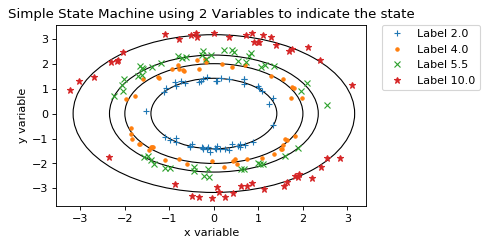

In [5]:
plot_xy_dataframe(simple_df, 'Simple State Machine using 2 Variables to indicate the state')

---

# Options

In [6]:
# This list includes all of the labels that will be included in the
# training and testing sets that will be used to train and then 
# evaluate the machine learning models we create below.
all_labels = [2,5]
number_of_classes = len(all_labels)

# The folders where the linear and dnn classifiers will be stored
# The model is stored and loaded automatically (yay)
linear_classifier_dir = './classifiers/linear_classifier'
dnn_classifier_dir = './classifiers/dnn_classifier'

# These options control how big the training and testing datasets produced will be
# More data == more accurate
# Too much data *might* produce over-fitting; see second notebook
num_training_samples=150
num_testing_samples=50

# number of training steps to perform
# 1000 is a good starting point, 
# use TensorBoard's loss graph to see if more steps are required
linear_steps = 1500
dnn_steps = 1500

# Simple method to convert from our labels to an index of the label
# Indexes are required for TensorFlow
label_lookup={} # Used in the input_fn to convert a label into an index (can be changed to be OneHotEncoding)
index_lookup={} # Used to convert predictions back into labels
curr_count = 0
for x in all_labels:
    label_lookup[x] = curr_count
    index_lookup[curr_count] = x
    curr_count += 1


# When preparing data for the machine learning model, we label our data
# This extra step of labelling the data with a name allows for easier understanding of the model
# because we can see where our data is flowing and what operations are being used for
# each feature
feature_x_name_current = "x"
feature_y_name_current = "y"

# this list describes the data we will be providing the machine learning model
# The data is normally called 'features'
# There are many types of features (see https://www.tensorflow.org/api_docs/python/tf/feature_column)
# shape describes how the data is formated
# shape=[12,3] -- this means that a single sample will have a feature with a matrix of 12 by 3
feature_columns = [
    tf.feature_column.numeric_column(feature_x_name_current, shape=[1]),
    tf.feature_column.numeric_column(feature_y_name_current, shape=[1])
]

# A looping cycle of colours; used for plotting
colours = itertools.cycle(['darkorange', 'seagreen', 'deepskyblue', 'darkorchid'])

---

# Create Training and Testing Sets

We will now need to create a time series data-stream that contains all states and are randomly placed in different sized chunks. Using this methodology of randomly switching from 1 state to another, and staying in each stay for a uniformly random time (between a minimum and maximum number of samples) will produce a training set that is could be time-series dependant.

Since we are using `circle_coord()`, there will be no time series dependencies.

The option to include time-series dependencies would be added here, having conditions of which states can transition to another and having transitional values to indicate that a state is changing.

Here are the input parameters for `getTimeSeriesData()`:
 * **labels** - a list of real/double numbers that will be used as the set of possible labels
 * **total_samples** - an integer representing the total number of samples to return (see force_minimum_samples for details about when this value is not strict)
 * **min_samples_per_label** - an integer representing the minimum number of samples that the state-machine must stay in a state before potentially leaving
 * **max_samples_per_label** - an integer representing the maximum number of samples that the state-machine is allowed to remain in a state before being forced to leave
 * **force_minimum_samples** - controls how many total samples are produced; in certain situations True or False will return the same number of samples.
   * When this is true, then the total_samples is not a hard limit, but a minimum and extra samples might be added to ensure that the last labelled data has at least min_samples_per_label. 
   * When False, then the total number of sample is equal to total_samples
 * **noise_func** - a function to generate noise, or None

The function resturns a `DataFrame({'x': x, 'y': y, 'label': label}, index=t)`
   * **x,y** are values returned from `circle_coord()`
   * **label** is a value from **labels**
   * **t** is the time that the sample was taken, normalized so that each sample is taken one after another (no time dilation feature)

In [7]:
def getTimeSeriesData(labels,
                      total_samples,
                      min_samples_per_label=15,
                      max_samples_per_label=30,
                      force_minimum_samples=False,
                      noise_func=small_noise):
    my_labels = list(labels)
    sample_counts = np.random.randint(
        min_samples_per_label, max_samples_per_label + 1,
        size=len(labels)).tolist()

    while math.fsum(sample_counts) < total_samples:
        sample_counts.append(
            random.randrange(min_samples_per_label, max_samples_per_label + 1))
        my_labels.append(random.choice(labels))

    random.shuffle(my_labels)

    if math.fsum(sample_counts) > total_samples:
        samples_to_cut = int(math.fsum(sample_counts)) - total_samples
        new_last_samples = sample_counts[-1] - samples_to_cut

        if new_last_samples >= min_samples_per_label or force_minimum_samples == False:
            sample_counts[-1] = new_last_samples
        else:
            sample_counts[-1] = min_samples_per_label

    t = [] # time
    x = [] # from circle_coord()
    y = [] # from circle_coord()
    label = [] 
    cur_time = 0
    for l, c in zip(my_labels, sample_counts):
        for v in range(1, c + 1):
            (tmp_x, tmp_y) = circle_coord(l, noise_func=noise_func)
            x.append(tmp_x)
            y.append(tmp_y)
            label.append(l)
            t.append(cur_time)
            cur_time += 1

    df = pd.DataFrame({'x': x, 'y': y, 'label': label}, index=t)
    return df

## Creating the Training Set

Normally you would not create a training and testing set separately, normally you would run your experiments and collect your data, then you would shuffle the data and then randomly split the dataset into 2 or 3 sets. Usually training gets 50%-70% of the data and the rest is given to the testing set. The 3rd possible set is not used here, but you can create another set to use for validation.

* **Training Set:** the training set is used to train the model
* **Testing Set:** the testing set is data not seen by the model during the training phase, and is used to compare different models accuracies.
* **Validation Set:** the validation set (not used in this notebook) is used to automatically pick values for a single model. Say there is a parameter that can take values between -5 and 5; we can train and test a whole bunch of models using different values from -5 to 5 and then use the model with the best validation set to be our model.
* **Difference between Testing and Validation:** the testing set is only used as a metric to compare models against each other, the validation set is used to specifically target a value and thus is considered another training step. The testing set accuracy is what you publish as your model's accuracy.


In [8]:
my_training_df = getTimeSeriesData(all_labels, num_training_samples, force_minimum_samples=True)
print('Column Names:',my_training_df.columns)
print('Shape (rows, columns):', my_training_df.shape)

Column Names: Index(['label', 'x', 'y'], dtype='object')
Shape (rows, columns): (153, 3)


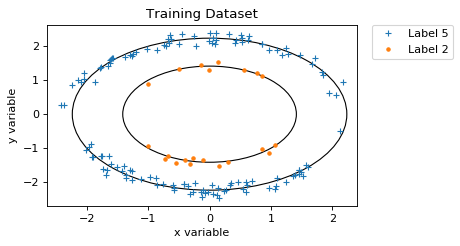

In [9]:
# Plot the training data
plot_xy_dataframe(my_training_df, 'Training Dataset')

## Creating the Testing Set

Column Names: Index(['label', 'x', 'y'], dtype='object')
Shape (rows, columns): (50, 3)


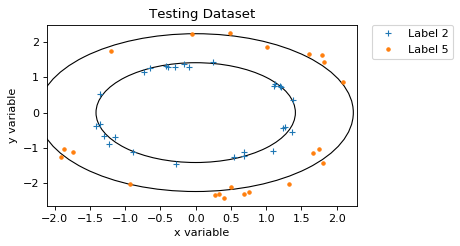

In [10]:
# Create a randomly generated testing set
my_testing_df = getTimeSeriesData(all_labels, num_testing_samples, force_minimum_samples=True)
print('Column Names:',my_testing_df.columns)
print('Shape (rows, columns):', my_testing_df.shape)

# Plot the testing data
plot_xy_dataframe(my_testing_df, 'Testing Dataset')

## Visualizing Both Datasets

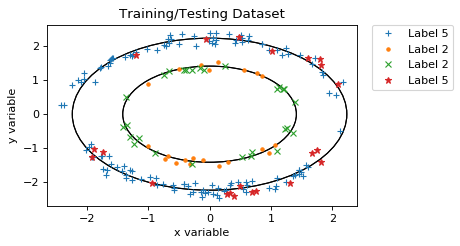

In [11]:
# Plot both Training and Testing Sets (Sanity Check!)
plot_xy_dataframe([my_training_df, my_testing_df], 'Training/Testing Dataset')

## Creating a Random Sample for Predicting

This section provides a function, `getRandomSamples()`, to create a number of random samples using randomly chosen labels.

The labels are printed in the output whenever this function is called:
```
[getRandomSamples] Samples: {
'x': array([-0.05208236, -0.3869589 , -1.13264816,  1.79492211,  0.8052926 , -0.01367383,  0.89702072, -0.6693063 ]), 
'y': array([-1.48665804, -2.22552121,  0.92402495,  1.55602302,  2.24557578, 1.36874261,  2.08458017,  1.38179618])}; 
Labels: [2, 5, 2, 5, 5, 2, 5, 2]
```

In [12]:
def getRandomSamples(num_samples, all_labels):
    x = []
    y = []
    labels = []
    idxs = []
    for a in range(0, num_samples):
        l, idx = randomchoice(all_labels)
        (tmp_x, tmp_y) = circle_coord(l, noise_func=small_noise)
        x.append(tmp_x)
        y.append(tmp_y)
        labels.append(l)
        idxs.append(idx)

    samples = {
        feature_x_name_current: np.array(x),
        feature_y_name_current: np.array(y)
    }
    # print(sample,labels)
    print('[getRandomSamples] Samples: {}; Labels: {}'.format(samples, labels))
    return samples, labels, idxs

---

# Input Function to the TensorFlow Model

The **input_fn** is used to pass feature and target data to the train, evaluate, and predict methods of the Estimator. The user can do feature engineering or pre-processing inside the `input_fn` or before this function is called.

How data flows in this notebook:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
raw data $\rightarrow$ preprocessing $\rightarrow$ input function $\rightarrow$ feature columns $\rightarrow$ model (train, evaluate, or predict)

In [13]:
# input_fn needs to return a function pointer (that requires no parameters),
# when executed the function pointer returns a tuple ([ [x1,x2,x3,x4,...,xn]],[label])
def input_fn(dataset, label_map):
    def _fn():
        features = {
            feature_x_name_current:tf.constant(dataset['x'].tolist(), dtype=tf.float32),
            feature_y_name_current:tf.constant(dataset['y'].tolist(), dtype=tf.float32)
        }
        labels = tf.constant(dataset['label'].map(label_map).tolist(), dtype=tf.int32)
        return features, labels
    return _fn

In the section below we are testing our `input_fn` function.

We first create a sample dataset with dummy values (increasing values 1-20 for $x$, and decreasing values for $y$), then we create a TensorFlow Graph and Session. 

A default graph is already created when we import TensorFlow, and every call to `tf.constant` and `tr.variable` (etc) adds a node to the default graph. We create a new empty graph for testing purposes (so as to not add sub-graphs to any other part of this notebook). `tf.estimator.*` will create their own graphs, like we do, for the same reasons. You do not need to understand Graphs and Sessions unless you want to evaluate Tensors outside of the TensorFlow models.

We use `with` to only use the `g_1` graph as the default within the `with` scope. Once a graph is created and set as the default graph, we then run `input_fn` and run the `_fn` function that is returned. This will return a dictionary of Tensors for the features and a Tensor for the labels. Once the `_fn` function is called, the tensors are added to the default graph (which is `g_1`).

We next create a Session, using the `with` scope for the same reasons as the Graph. The Session is used to actually run the graph. A session fills a graph with specific values, so 1 graph can be made and then multiple sessions can run different data through them (or 1 session, but more information can be learned here: https://www.tensorflow.org/programmers_guide/graphs).

We must initialize the global variables in the session before we can run any Tensors: `session.run(tf.global_variables_initializer())`. Next we run the Tensors that we want to solve, and feed no data into the session. We feed no data because the Tensors we are running are constants and already have data in them.

In our example we run the `feature_x_name_current`, `feature_y_name_current`, and the label Tenors. The output is stored in three variables, the order determined by the order the Tensors are run.

We then print out the data.

In [14]:
test_dataset = pd.DataFrame(
    {
        'x': range(1, 26 + 1),
        'y': range(26, 0, -1),
        'label': [2, 5] * 13
    },
    index=range(1, 26 + 1))

g_1 = tf.Graph() # Create a new graph
with g_1.as_default(): # sete the graph as default just within this scope
    # Call input_fn()() and have all tensors be added to g_1 (since it is the default graph now)
    # Notice that the Tenor name always restarts when a new graph is created: Const:0, Const_1:0, ...
    a = input_fn(test_dataset, label_lookup)()
    print('What input_fn()() returns:',a)
    nl()

    with tf.Session() as session:
        session.run(tf.global_variables_initializer())

        x1, x2, l = session.run([
            a[0][feature_x_name_current], a[0][feature_y_name_current],
            a[1]
        ])
        print('Variable {}:'.format(feature_x_name_current), x1)
        print('Variable {}:'.format(feature_y_name_current), x2)
        print('Labels:', l)

    nl()
        
    a = input_fn(my_training_df, label_lookup)()
    print('Notice that new Tensors are created each time the input_fn()() is called. ex: Const_3:0')
    print(a)

What input_fn()() returns: ({'x': <tf.Tensor 'Const:0' shape=(26,) dtype=float32>, 'y': <tf.Tensor 'Const_1:0' shape=(26,) dtype=float32>}, <tf.Tensor 'Const_2:0' shape=(26,) dtype=int32>)

Variable x: [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.]
Variable y: [ 26.  25.  24.  23.  22.  21.  20.  19.  18.  17.  16.  15.  14.  13.  12.
  11.  10.   9.   8.   7.   6.   5.   4.   3.   2.   1.]
Labels: [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]

Notice that new Tensors are created each time the input_fn()() is called. ex: Const_3:0
({'x': <tf.Tensor 'Const_3:0' shape=(153,) dtype=float32>, 'y': <tf.Tensor 'Const_4:0' shape=(153,) dtype=float32>}, <tf.Tensor 'Const_5:0' shape=(153,) dtype=int32>)


---

# Linear Classifier

Linear classifiers learn a set of weights that are used to split an $X$ dimensional vector space into multiple regions, where $X$ is the number of features given to the classifier. These regions are then labelled, and any sample given to the model will return the label that it falls within. Regions can overlap and thus the result for a sample is usually a list of probabilities, where each probability is how much a sample is in a region with a particular label. The Linear Classifier will perform a `softmax` and return the class/label with the highest probability.

It is easy to imagine linear classifiers as drawing lines in 2 dimensions to split the input space into multiple enclosed areas, where each area has a designated label. Whichever area a sample falls in will be the predicted label. For linear classifiers that return percentages for labels, the areas can be thought of as overlapping.

The linear classifier we are building below is a standard Linear Classifier [tf.estimator.LinearClassifier](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier), it returns
```json
{
    'logits': array([-0.35682946,  0.45714393,  0.42588502], dtype=float32), 
    'probabilities': array([ 0.18367968,  0.41453892,  0.40178132], dtype=float32), 
    'class_ids': array([1], dtype=int64), 
    'classes': array([b'1'], dtype=object)
}
```

API Reference: https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier

## Cleaning the Linear Classifier Folder

Training a classifier in TensorFlow will automatically save the model to the directory. This ensures that you do not lose any progress you have made when training and can resume training or use a checkpoint (checkpoints are made periodically during training) to continue training if the process must be paused or if new data arrives.

Because of this, if you change the classifier's features then you need to change the directory or delete the contents of that directory. The module below will delete all files within the supplied directory.

In [15]:
clean_dir(linear_classifier_dir)

## Creating the TensorFlow Linear Model

`tf.estimator.LinearClassifier()`
* **feature_columns:** An iterable containing all the feature columns used by the model. All items in the set should be instances of classes derived from FeatureColumn.
* **model_dir:** Directory to save model parameters, graph and etc. This can also be used to load checkpoints from the directory into a estimator to continue training a previously saved model.
* **n_classes:** number of label classes. Default is binary classification. Note that class labels are integers representing the class index (i.e. values from 0 to n_classes-1). For arbitrary label values (e.g. string labels), convert to class indices first.
* **weight_column:** A string or a _NumericColumn created by tf.feature_column.numeric_column defining feature column representing weights. It is used to down weight or boost examples during training. It will be multiplied by the loss of the example. If it is a string, it is used as a key to fetch weight tensor from the features. If it is a _NumericColumn, raw tensor is fetched by key weight_column.key, then weight_column.normalizer_fn is applied on it to get weight tensor.
* **label_vocabulary:** A list of strings represents possible label values. If given, labels must be string type and have any value in label_vocabulary. If it is not given, that means labels are already encoded as integer or float within [0, 1] for n_classes=2 and encoded as integer values in {0, 1,..., n_classes-1} for n_classes>2 . Also there will be errors if vocabulary is not provided and labels are string.
* **optimizer:** An instance of tf.Optimizer used to train the model. Defaults to FTRL optimizer.
* **config:** RunConfig object to configure the runtime settings.
* **partitioner:** Optional. Partitioner for input layer.

`tf.estimator.RunConfig()` has many options, the 2 we will use are:
 * **log_step_count_steps:** this is how often the classifier will output to the console
 * **save_summary_steps:** this is how often data is saved during training (which will be used in TensorBoard)

In [16]:
# Setting up the machine learning model is really this simple
# If a model is already stored in the `model_dir`, then it will be loaded into memory
# If the model in `model_dir` is different than `feature_colums` an error will occur
#     must change dir or delete model in `model_dir`
linear_classifier = tf.estimator.LinearClassifier(
    # REQUIRED
    feature_columns=feature_columns,
    # REQUIRED IF NOT = 2
    n_classes=number_of_classes,
    ###
    # CHANGE FOR BETTER ACCURACY (see DNN for different optimizers)
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    ###
    model_dir=linear_classifier_dir,
    config=tf.estimator.RunConfig().replace(log_step_count_steps=50).replace(
        save_summary_steps=1))

INFO:tensorflow:Using config: {'_model_dir': './classifiers/linear_classifier', '_tf_random_seed': 1, '_save_summary_steps': 1, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 50}


## Training the TensorFlow Linear Model

Trains a model given training data through an input function `input_fn`.

`tf.estimator.train()`
* **input_fn:** Input function returning a tuple of: (features, labels)
  * features - Tensor or dictionary of string feature name to Tensor. 
  * labels - Tensor or dictionary of Tensor with labels.
* **steps:** Number of steps for which to train model. If None, train forever or train until input_fn generates the OutOfRange or StopIteration error. 'steps' works incrementally. If you call two times train(steps=10) then training occurs in total 20 steps. If OutOfRange or StopIteration error occurs in the middle, training stops before 20 steps. If you don't want to have incremental behavior please set max_steps instead. If set, max_steps must be None.
* **max_steps:** Number of total steps for which to train model. If None, train forever or train until input_fn generates the OutOfRange or StopIteration error. If set, steps must be None. If OutOfRange or StopIteration error occurs in the middle, training stops before max_steps steps.
  
  Two calls to train(steps=100) means 200 training iterations. On the other hand, two calls to train(max_steps=100) means that the second call will not do any iteration since first call did all 100 steps.
* **hooks:** List of SessionRunHook subclass instances. Used for callbacks inside the training loop.

In [17]:
linear_classifier.train(input_fn=input_fn(my_training_df,label_lookup), steps=linear_steps)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./classifiers/linear_classifier\model.ckpt.
INFO:tensorflow:loss = 106.052, step = 1
INFO:tensorflow:global_step/sec: 1110.34
INFO:tensorflow:global_step/sec: 1189.61
INFO:tensorflow:loss = 72.4586, step = 101 (0.087 sec)
INFO:tensorflow:global_step/sec: 1086.17
INFO:tensorflow:global_step/sec: 1162
INFO:tensorflow:loss = 66.6951, step = 201 (0.090 sec)
INFO:tensorflow:global_step/sec: 1040.91
INFO:tensorflow:global_step/sec: 1161.96
INFO:tensorflow:loss = 64.1222, step = 301 (0.091 sec)
INFO:tensorflow:global_step/sec: 1040.94
INFO:tensorflow:global_step/sec: 819.078
INFO:tensorflow:loss = 62.7689, step = 401 (0.109 sec)
INFO:tensorflow:global_step/sec: 1135.58
INFO:tensorflow:global_step/sec: 1218.67
INFO:tensorflow:loss = 61.9966, step = 501 (0.085 sec)
INFO:tensorflow:global_step/sec: 1135.55
INFO:tensorflow:global_step/sec: 1161.95
INFO:tensorflow:loss = 61.5335, step = 601 (0.087 sec)
INFO:t

## Evaluating the TensorFlow Linear Model

Evaluating a machine learning model is when we have the model predict known data (already labelled data) and then compare the predicted label with what is known label and summarize these comparisons with several different statistical properties: accuracy, loss, AUC, ...

`tf.estimator.LinearClassifier.evaluate()`
* **input_fn:** Input function returning a tuple of: 
   * features - Dictionary of string feature name to `Tensor` or `SparseTensor`. 
   * labels - Tensor or dictionary of Tensor with labels.
* **steps:** Number of steps for which to evaluate model. If None, evaluates until input_fn raises an end-of-input exception.
* **name:** Name of the evaluation if user needs to run multiple evaluations on different data sets, such as on training data vs test data. Metrics for different evaluations are saved in separate folders, and appear separately in tensorboard.
* **checkpoint_path:** Path of a specific checkpoint to evaluate. If None, the latest checkpoint in model_dir is used.
* **hooks:** List of SessionRunHook subclass instances. Used for callbacks inside the evaluation call.

Below we are evaluating the model on both the training and testing datasets. We use the testing set to indicate how good the model is, but we use the training set to understand if the testing set's accuracy is bad (more on this later).

In [18]:
linear_evaluation_training = linear_classifier.evaluate(
    input_fn=input_fn(my_training_df, label_lookup),
    steps=len(my_training_df[feature_x_name_current]), # evaluate the whole training dataset
    name='Training Data')
linear_evaluation_testing = linear_classifier.evaluate(
    input_fn=input_fn(my_testing_df, label_lookup),
    steps=len(my_testing_df[feature_x_name_current]), #evaluate the whole testing dataset
    name='Testing Data')

INFO:tensorflow:Starting evaluation at 2017-10-17-15:07:59
INFO:tensorflow:Restoring parameters from ./classifiers/linear_classifier\model.ckpt-1500
INFO:tensorflow:Evaluation [1/153]
INFO:tensorflow:Evaluation [2/153]
INFO:tensorflow:Evaluation [3/153]
INFO:tensorflow:Evaluation [4/153]
INFO:tensorflow:Evaluation [5/153]
INFO:tensorflow:Evaluation [6/153]
INFO:tensorflow:Evaluation [7/153]
INFO:tensorflow:Evaluation [8/153]
INFO:tensorflow:Evaluation [9/153]
INFO:tensorflow:Evaluation [10/153]
INFO:tensorflow:Evaluation [11/153]
INFO:tensorflow:Evaluation [12/153]
INFO:tensorflow:Evaluation [13/153]
INFO:tensorflow:Evaluation [14/153]
INFO:tensorflow:Evaluation [15/153]
INFO:tensorflow:Evaluation [16/153]
INFO:tensorflow:Evaluation [17/153]
INFO:tensorflow:Evaluation [18/153]
INFO:tensorflow:Evaluation [19/153]
INFO:tensorflow:Evaluation [20/153]
INFO:tensorflow:Evaluation [21/153]
INFO:tensorflow:Evaluation [22/153]
INFO:tensorflow:Evaluation [23/153]
INFO:tensorflow:Evaluation [24/1

INFO:tensorflow:Saving dict for global step 1500: accuracy = 0.44, accuracy_baseline = 0.56, auc = 0.357955, auc_precision_recall = 0.463501, average_loss = 1.15832, global_step = 1500, label/mean = 0.44, loss = 57.9158, prediction/mean = 0.846543


In [19]:
print('\nTraining Accuracy: {0:f}%; '.format(linear_evaluation_training['accuracy']*100), end='')
if linear_evaluation_training['accuracy'] < 0.98:
    print('This accuracy is terrible')
else:
    print('This accuracy is good enough for training data.')
    
for key in sorted(linear_evaluation_training):
    print("    %s: %s" % (key, linear_evaluation_training[key]))
    
print('\nTesting Accuracy: {0:0f}%; '.format(linear_evaluation_testing['accuracy']*100), end='')
if linear_evaluation_testing['accuracy'] < 0.94:
    print('This accuracy is terrible')
else:
    print('This accuracy is good enough for testing data.')
    
for key in sorted(linear_evaluation_testing):
    print("    %s: %s" % (key, linear_evaluation_testing[key]))
    
# record accuracy for results table
lin_training_acc=linear_evaluation_training['accuracy']*100
lin_testing_acc=linear_evaluation_testing['accuracy']*100
lin_result_string = ['Linear','AdagradOptimizer(0.05)', 'N/A', 'N/A',
                      '{:0.2f}%'.format(lin_training_acc), '{:0.2f}%'.format(lin_testing_acc),getDT()]


Training Accuracy: 86.274511%; This accuracy is terrible
    accuracy: 0.862745
    accuracy_baseline: 0.862745
    auc: 0.566017
    auc_precision_recall: 0.916572
    average_loss: 0.396985
    global_step: 1500
    label/mean: 0.862745
    loss: 60.7387
    prediction/mean: 0.856975

Testing Accuracy: 44.000000%; This accuracy is terrible
    accuracy: 0.44
    accuracy_baseline: 0.56
    auc: 0.357955
    auc_precision_recall: 0.463501
    average_loss: 1.15832
    global_step: 1500
    label/mean: 0.44
    loss: 57.9158
    prediction/mean: 0.846543


## Predicting using the Linear Model

In order to actually use a machine learning model, we need some way to feed data into the model and for it to spit out a label. The `evaluation` function wraps the `predict` function, in order to compare the labels of known samples to the labels produced by the model.

In this section we are going to show how to predict/compute the labels for unknown samples.

Note: `predict_input_fn()` returns a function that then returns a tuple `(features, None)`, where we don't care about the second value of the tuple, it can be any value, thus we can use `input_fn()` without issue.

Below we are defining a prediction function that looks similar to `input_fn()`. The purpose of this function is to prepare the samples into Tensors that we can then feed into the model.

In [20]:
# return _fn() -> tuple (features, None)
def predict_input_fn(num_samples):
    samples, labels, idxs = getRandomSamples(num_samples, all_labels)
    return tf.estimator.inputs.numpy_input_fn(
        x=samples, 
        # num_epochs==1:    means that we will only run through the data once (useful during evaluation and prediction);
        # num_epochs==None: means it loops through the data forever (this is useful during training)
        num_epochs=1, 
        shuffle=False)

The code below sets up a generator object that will be able to run samples through the `linear_classifier` model but doesn't actually run the model in this step.

`tf.estimator.LinearClassifier.predict()`
* **input_fn:** Input function returning features which is a dictionary of string feature name to `Tensor` or `SparseTensor`. If it returns a tuple, first item is extracted as features. Prediction continues until `input_fn` raises an end-of-input exception (`OutOfRangeError` or `StopIteration`).
* **predict_keys:** list of `str`, name of the keys to predict. It is used if the `EstimatorSpec`.predictions is a dict. If `predict_keys` is used then rest of the predictions will be filtered from the dictionary. If None, returns all.
* **hooks:** List of `SessionRunHook` subclass instances. Used for callbacks inside the prediction call.
* **checkpoint_path:** Path of a specific checkpoint to predict. If None, the latest checkpoint in `model_dir` is used.

In [21]:
predict_num_samples = 8
predictions = linear_classifier.predict(input_fn=predict_input_fn(predict_num_samples))
nl()
print('Predictions Variable:', predictions)

[getRandomSamples] Samples: {'x': array([-0.39170739, -0.30149053, -1.0075345 , -0.78532735,  0.821949  ,
       -1.33705711,  0.98263588,  1.21829246]), 'y': array([-1.29189746,  1.32875958, -0.87238558,  1.25003774,  2.16998865,
        0.19905365,  0.95979681, -1.96390745])}; Labels: [2, 2, 2, 2, 5, 2, 2, 5]

Predictions Variable: <generator object Estimator.predict at 0x000001D6E46B5200>


`predictions` is a generator, which means that it only predicts when `next()` is call on it. We iterate through `predictions` using a for loop (which calls `next()`). If `num_epochs=None`, then this would be an infinite loop.

We use the `index_lookup` to convert the index of our label into the actual label. If our label was a string, then we would be able to use `predict_keys` in `tf.estimator.LinearClassifier.predict()` to automatically do this for us.

In [22]:
predicted_classes = [p["class_ids"] for p in predictions]
for p in predicted_classes:
    print('Class Id:', p, 'Actual Class Value:', index_lookup[p[0]])

INFO:tensorflow:Restoring parameters from ./classifiers/linear_classifier\model.ckpt-1500
Class Id: [1] Actual Class Value: 5
Class Id: [1] Actual Class Value: 5
Class Id: [1] Actual Class Value: 5
Class Id: [1] Actual Class Value: 5
Class Id: [1] Actual Class Value: 5
Class Id: [1] Actual Class Value: 5
Class Id: [1] Actual Class Value: 5
Class Id: [1] Actual Class Value: 5


## Visualizing the Model

A technique for visualizing 1, 2, and 3 dimensional machine learning algorithms is to brute force an area and see where the boundaries lie.

In [23]:
# OPTION: set the number of points in each direction
#    total points = vis_num_points^2
vis_num_points = 15


vis_x_points = []
vis_y_points = []
for vis_x in np.linspace( -5, 5, vis_num_points ):
    for vis_y in np.linspace( -5, 5, 10 ):
        vis_x_points.append(vis_x)
        vis_y_points.append(vis_y)

INFO:tensorflow:Restoring parameters from ./classifiers/linear_classifier\model.ckpt-1500


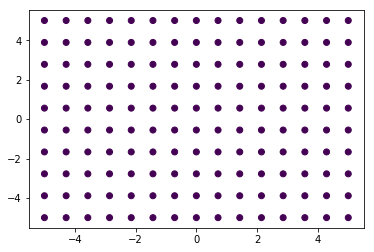

In [24]:
# Create the prediction model
vis_predictions = linear_classifier.predict(input_fn=tf.estimator.inputs.numpy_input_fn(x={
        feature_x_name_current: np.array(vis_x_points),
        feature_y_name_current: np.array(vis_y_points)
    }, num_epochs=1, shuffle=False))

# Run the model by looking up each predicted class
vis_predicted_classes = [index_lookup[p["class_ids"][0]] for p in vis_predictions]
# Create a dataframe to store the results (easier to plot)
vis_df = pd.DataFrame({'x': vis_x_points, 'y':vis_y_points, 'label': vis_predicted_classes})
#print(vis_df)

# Plot each label
plt.figure()
plt.scatter(x=vis_df.x, y=vis_df.y, c=vis_df.label)
plt.show()

---

# (Deep) Neural Network Classifier

Neural Networks is a series of connected nodes, where each node has an activation function that will give an output depending on the sum of input strengths. Deep Neural Networks means that there are multiple layers of connected nodes. The more nodes and the more connections allow for more complex relationships.

A good primer on neural networks is: http://neuralnetworksanddeeplearning.com/chap1.html

API Reference: https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier

## Cleaning the DNN Classifier Folder

In [25]:
clean_dir(dnn_classifier_dir)

## Creating the TensorFlow DNN Model

`tf.estimator.DNNClassifier()`
* **hidden_units:** Iterable of number hidden units per layer. All layers are fully connected. Ex. [64, 32] means first layer has 64 nodes and second one has 32.
* **feature_columns:** An iterable containing all the feature columns used by the model. All items in the set should be instances of classes derived from `_FeatureColumn`.
* **model_dir:** Directory to save model parameters, graph and etc. This can also be used to load checkpoints from the directory into a estimator to continue training a previously saved model.
* **n_classes:** Number of label classes. Defaults to 2, namely binary classification. Must be > 1.
* **weight_column:** A string or a `_NumericColumn` created by tf.feature_column.numeric_column defining feature column representing weights. It is used to down weight or boost examples during training. It will be multiplied by the loss of the example. If it is a string, it is used as a key to fetch weight tensor from the features. If it is a `_NumericColumn`, raw tensor is fetched by key weight_column.key, then `weight_column.normalizer_fn` is applied on it to get weight tensor.
* **label_vocabulary:** A list of strings represents possible label values. If given, labels must be string type and have any value in label_vocabulary. If it is not given, that means labels are already encoded as integer or float within [0, 1] for n_classes=2 and encoded as integer values in {0, 1,..., n_classes-1} for n_classes>2. Also there will be errors if vocabulary is not provided and labels are string.
* **optimizer:** An instance of tf.Optimizer used to train the model. Defaults to Adagrad optimizer.
* **activation_fn:** Activation function applied to each layer. If None, will use tf.nn.relu.
* **dropout:** When not None, the probability we will drop out a given coordinate.
* **input_layer_partitioner:** Optional. Partitioner for input layer. Defaults to min_max_variable_partitioner with min_slice_size 64 << 20.
* **config:** RunConfig object to configure the runtime settings.

In [26]:
dnn_classifier = tf.estimator.DNNClassifier(
    # REQUIRED
    feature_columns=feature_columns,
    # REQUIRED IF NOT BINARY CLASSIFIER (WHEN len(all_labels) != 2)
    n_classes=len(all_labels),
    ###
    # CHANGE THIS FOR BETTER/WORSE ACCURACY
    hidden_units=[4,5], 
    # CHANGE THIS FOR BETTER/WORSE ACCURACY
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    # CHANGE THIS FOR BETTER/WORSE ACCURACY
    activation_fn=tf.nn.tanh,
    ###
    model_dir=dnn_classifier_dir,
    config=tf.estimator.RunConfig().replace(log_step_count_steps=50).replace(save_summary_steps=1)
)

INFO:tensorflow:Using config: {'_model_dir': './classifiers/dnn_classifier', '_tf_random_seed': 1, '_save_summary_steps': 1, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 50}


### Picking Hidden Layer Sizes

<img style="width: 40%" src="figs/hidden-layers.png"/>

The number of hidden layers (`L` in the figure) and the number of nodes to be in each layer (denoted `N` in figure) have no algorithm to calculate them. There are some 'rules of thumb' that provide direction but experimentation is required to find the best values from each information domain.

Note: adding more layers and nodes will increase training and prediction times and can over fit the data, but if your data is very complex then more nodes are usually required.

"These rules of thumb are nonsense because they ignore the number of training
cases, the amount of noise in the targets, and the complexity of the function."

Reference: http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html

### List of Optimizers

An Optimizer is an algorithm that is run during training to update and change the internal weights in a machine learning model, so that the model can more accurately model the input data. There are many, many different optimization algorithms, some already implemented in TensorFlow are listed below.

* tr.train.AdadeltaOptimizer  -- https://www.tensorflow.org/api_docs/python/tf/train/AdadeltaOptimizer
* tr.train.AdagradDAOptimizer  -- https://www.tensorflow.org/api_docs/python/tf/train/AdagradDAOptimizer
* tr.train.AdagradOptimizer  -- https://www.tensorflow.org/api_docs/python/tf/train/AdagradOptimizer
* tr.train.AdamOptimizer  -- https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer
* tr.train.FtrlOptimizer  -- https://www.tensorflow.org/api_docs/python/tf/train/FtrlOptimizer
* tr.train.GradientDescentOptimizer  -- https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer
* tr.train.MomentumOptimizer  -- https://www.tensorflow.org/api_docs/python/tf/train/MomentumOptimizer
* tr.train.ProximalAdagradOptimizer  -- https://www.tensorflow.org/api_docs/python/tf/train/ProximalAdagradOptimizer
* tr.train.ProximalGradientDescentOptimizer  -- https://www.tensorflow.org/api_docs/python/tf/train/ProximalGradientDescentOptimizer
* tr.train.RMSPropOptimizer  -- https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer
* tr.train.SyncReplicasOptimizer  -- https://www.tensorflow.org/api_docs/python/tf/train/SyncReplicasOptimizer

<img src="figs/optimizers.gif"/>
Source: https://imgur.com/a/Hqolp

### List of Activation Functions

The activation function controls how the DNN is able to model the data. This is some times hard to imagine, but a good way to see the affects the activation function can have is to play with: http://playground.tensorflow.org. Pick different inputs and then change the activation function and see how well certain activation functions model different relationships. I have found `tanh` to be able to model circles within each other for 2 dimensions; `sigmoid` is also able to do this, but it takes many more steps to reach this result; `linear` is unable to model this relationship.

* `tf.nn.relu` -- https://www.tensorflow.org/api_docs/python/tf/nn/relu
* `tf.nn.relu6` -- https://www.tensorflow.org/api_docs/python/tf/nn/relu6
* `tf.nn.crelu` -- https://www.tensorflow.org/api_docs/python/tf/nn/crelu
* `tf.nn.elu` -- https://www.tensorflow.org/api_docs/python/tf/nn/elu
* `tf.nn.softplus` -- https://www.tensorflow.org/api_docs/python/tf/nn/softplus
* `tf.nn.softsign` -- https://www.tensorflow.org/api_docs/python/tf/nn/softsign
* `tf.nn.dropout` -- https://www.tensorflow.org/api_docs/python/tf/nn/dropout
* `tf.nn.bias_add` -- https://www.tensorflow.org/api_docs/python/tf/nn/bias_add
* `tf.nn.sigmoid` -- https://www.tensorflow.org/api_docs/python/tf/sigmoid
* `tf.nn.tanh` -- https://www.tensorflow.org/api_docs/python/tf/tanh

<img src="figs/activation-function.png"/>
Source: https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59


Other visualizations of activation functions: https://stats.stackexchange.com/questions/115258/comprehensive-list-of-activation-functions-in-neural-networks-with-pros-cons

## Training the TensorFlow DNN Model

`tf.estimator.train()`
* **input_fn:** Input function returning a tuple of: (features, labels)
  * features - Tensor or dictionary of string feature name to Tensor. 
  * labels - Tensor or dictionary of Tensor with labels.
* **steps:** Number of steps for which to train model. If None, train forever or train until input_fn generates the OutOfRange or StopIteration error. 'steps' works incrementally. If you call two times train(steps=10) then training occurs in total 20 steps. If OutOfRange or StopIteration error occurs in the middle, training stops before 20 steps. If you don't want to have incremental behavior please set max_steps instead. If set, max_steps must be None.
* **max_steps:** Number of total steps for which to train model. If None, train forever or train until input_fn generates the OutOfRange or StopIteration error. If set, steps must be None. If OutOfRange or StopIteration error occurs in the middle, training stops before max_steps steps.
  
  Two calls to train(steps=100) means 200 training iterations. On the other hand, two calls to train(max_steps=100) means that the second call will not do any iteration since first call did all 100 steps.
* **hooks:** List of SessionRunHook subclass instances. Used for callbacks inside the training loop.

In [27]:
dnn_classifier.train(
    input_fn=input_fn(my_training_df, label_lookup), steps=dnn_steps)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./classifiers/dnn_classifier\model.ckpt.
INFO:tensorflow:loss = 105.627, step = 1
INFO:tensorflow:global_step/sec: 364.184
INFO:tensorflow:global_step/sec: 364.324
INFO:tensorflow:loss = 50.2249, step = 101 (0.277 sec)
INFO:tensorflow:global_step/sec: 306.549
INFO:tensorflow:global_step/sec: 319.057
INFO:tensorflow:loss = 36.7448, step = 201 (0.320 sec)
INFO:tensorflow:global_step/sec: 273.031
INFO:tensorflow:global_step/sec: 316.814
INFO:tensorflow:loss = 19.362, step = 301 (0.341 sec)
INFO:tensorflow:global_step/sec: 287.948
INFO:tensorflow:global_step/sec: 324.502
INFO:tensorflow:loss = 7.22087, step = 401 (0.328 sec)
INFO:tensorflow:global_step/sec: 297.407
INFO:tensorflow:global_step/sec: 317.361
INFO:tensorflow:loss = 3.54356, step = 501 (0.326 sec)
INFO:tensorflow:global_step/sec: 304.665
INFO:tensorflow:global_step/sec: 355.501
INFO:tensorflow:loss = 2.19176, step = 601 (0.305 sec)
INFO:te

## Evaluating the TensorFlow DNN Model

Evaluating a machine learning model is when we have the model predict known data (already labelled data) and then compare the predicted label with what is known label and summarize these comparisons with several different statistical properties: accuracy, loss, AUC, ...

`tf.estimator.DNNClassifier.evaluate()`
* **input_fn:** Input function returning a tuple of: 
   * features - Dictionary of string feature name to `Tensor` or `SparseTensor`. 
   * labels - Tensor or dictionary of Tensor with labels.
* **steps:** Number of steps for which to evaluate model. If None, evaluates until input_fn raises an end-of-input exception.
* **name:** Name of the evaluation if user needs to run multiple evaluations on different data sets, such as on training data vs test data. Metrics for different evaluations are saved in separate folders, and appear separately in tensorboard.
* **checkpoint_path:** Path of a specific checkpoint to evaluate. If None, the latest checkpoint in model_dir is used.
* **hooks:** List of SessionRunHook subclass instances. Used for callbacks inside the evaluation call.

In [28]:
dnn_evaluation_training = dnn_classifier.evaluate(
    input_fn=input_fn(my_training_df, label_lookup),
    steps=len(my_training_df.index),
    name='Training Data')
dnn_evaluation_testing = dnn_classifier.evaluate(
    input_fn=input_fn(my_testing_df, label_lookup),
    steps=len(my_testing_df.index),
    name='Testing Data')

INFO:tensorflow:Starting evaluation at 2017-10-17-15:08:13
INFO:tensorflow:Restoring parameters from ./classifiers/dnn_classifier\model.ckpt-1500
INFO:tensorflow:Evaluation [1/153]
INFO:tensorflow:Evaluation [2/153]
INFO:tensorflow:Evaluation [3/153]
INFO:tensorflow:Evaluation [4/153]
INFO:tensorflow:Evaluation [5/153]
INFO:tensorflow:Evaluation [6/153]
INFO:tensorflow:Evaluation [7/153]
INFO:tensorflow:Evaluation [8/153]
INFO:tensorflow:Evaluation [9/153]
INFO:tensorflow:Evaluation [10/153]
INFO:tensorflow:Evaluation [11/153]
INFO:tensorflow:Evaluation [12/153]
INFO:tensorflow:Evaluation [13/153]
INFO:tensorflow:Evaluation [14/153]
INFO:tensorflow:Evaluation [15/153]
INFO:tensorflow:Evaluation [16/153]
INFO:tensorflow:Evaluation [17/153]
INFO:tensorflow:Evaluation [18/153]
INFO:tensorflow:Evaluation [19/153]
INFO:tensorflow:Evaluation [20/153]
INFO:tensorflow:Evaluation [21/153]
INFO:tensorflow:Evaluation [22/153]
INFO:tensorflow:Evaluation [23/153]
INFO:tensorflow:Evaluation [24/153]

INFO:tensorflow:Finished evaluation at 2017-10-17-15:08:17
INFO:tensorflow:Saving dict for global step 1500: accuracy = 0.94, accuracy_baseline = 0.56, auc = 1.0, auc_precision_recall = 1.0, average_loss = 0.0936338, global_step = 1500, label/mean = 0.44, loss = 4.68169, prediction/mean = 0.499131


In [29]:
print('Training Accuracy: {0:f}%; '.format(dnn_evaluation_training['accuracy']*100), end='')
if dnn_evaluation_training['accuracy'] < 0.98:
    print('This accuracy is terrible')
else:
    print('This accuracy is good enough for training data.')
    
for key in sorted(dnn_evaluation_training):
    print("    %s: %s" % (key, dnn_evaluation_training[key]))
    
nl()
    
print('Testing Accuracy: {0:0f}%; '.format(dnn_evaluation_testing['accuracy']*100), end='')
if dnn_evaluation_testing['accuracy'] < 0.94:
    print('This accuracy is terrible')
else:
    print('This accuracy is good enough for testing data.')
    
for key in sorted(dnn_evaluation_testing):
    print("    %s: %s" % (key, dnn_evaluation_testing[key]))
    
nl()

if dnn_evaluation_training['accuracy'] >= 0.96 and dnn_evaluation_testing['accuracy'] < 0.90:
    print('Observation: It look looks like you are over fitting the problem, try reducing the number of hidden layers.')
    
# record accuracy for results table
dnn_training_acc=dnn_evaluation_training['accuracy']*100
dnn_testing_acc=dnn_evaluation_testing['accuracy']*100
dnn_result_string = ['DNN','AdagradOptimizer(0.05)', 'tanh', '[10,5]',
                      '{:0.2f}%'.format(dnn_training_acc), '{:0.2f}%'.format(dnn_testing_acc),getDT()]

Training Accuracy: 100.000000%; This accuracy is good enough for training data.
    accuracy: 1.0
    accuracy_baseline: 0.862745
    auc: 1.0
    auc_precision_recall: 1.0
    average_loss: 0.00280268
    global_step: 1500
    label/mean: 0.862745
    loss: 0.42881
    prediction/mean: 0.862303

Testing Accuracy: 94.000000%; This accuracy is terrible
    accuracy: 0.94
    accuracy_baseline: 0.56
    auc: 1.0
    auc_precision_recall: 1.0
    average_loss: 0.0936338
    global_step: 1500
    label/mean: 0.44
    loss: 4.68169
    prediction/mean: 0.499131



## Predicting using the DNN Model

`tf.estimator.DNNClassifier.predict()`
* **input_fn:** Input function returning features which is a dictionary of string feature name to `Tensor` or `SparseTensor`. If it returns a tuple, first item is extracted as features. Prediction continues until `input_fn` raises an end-of-input exception (`OutOfRangeError` or `StopIteration`).
* **predict_keys:** list of `str`, name of the keys to predict. It is used if the `EstimatorSpec`.predictions is a dict. If `predict_keys` is used then rest of the predictions will be filtered from the dictionary. If None, returns all.
* **hooks:** List of `SessionRunHook` subclass instances. Used for callbacks inside the prediction call.
* **checkpoint_path:** Path of a specific checkpoint to predict. If None, the latest checkpoint in `model_dir` is used.

In [30]:
predictions = dnn_classifier.predict(input_fn=predict_input_fn(predict_num_samples))

predicted_classes = [p["class_ids"] for p in predictions]
for p in predicted_classes:
    print('Class Id:', p, 'Actual Class Value:', index_lookup[p[0]])

[getRandomSamples] Samples: {'x': array([ 1.46006261,  2.05125538, -0.06273653, -0.26178963, -0.56318826,
       -1.52557857,  1.59968965, -1.07519202]), 'y': array([ 1.67178784,  1.08886789,  1.32830215, -1.49933749, -1.24574966,
        0.14045254, -1.35439916, -1.0118813 ])}; Labels: [5, 5, 2, 2, 2, 2, 5, 2]
INFO:tensorflow:Restoring parameters from ./classifiers/dnn_classifier\model.ckpt-1500
Class Id: [1] Actual Class Value: 5
Class Id: [1] Actual Class Value: 5
Class Id: [0] Actual Class Value: 2
Class Id: [0] Actual Class Value: 2
Class Id: [0] Actual Class Value: 2
Class Id: [0] Actual Class Value: 2
Class Id: [1] Actual Class Value: 5
Class Id: [0] Actual Class Value: 2


## Visualizing the Model

A technique for visualizing 1, 2, and 3 dimensional machine learning algorithms is to brute force an area and see where the boundaries lie.

In [31]:
# OPTION: set the number of points in each direction
#    total points = vis_num_points^2
vis_num_points = 50


vis_x_points = []
vis_y_points = []
for vis_x in np.linspace( -5, 5, vis_num_points ):
    for vis_y in np.linspace( -5, 5, 10 ):
        vis_x_points.append(vis_x)
        vis_y_points.append(vis_y)

INFO:tensorflow:Restoring parameters from ./classifiers/dnn_classifier\model.ckpt-1500


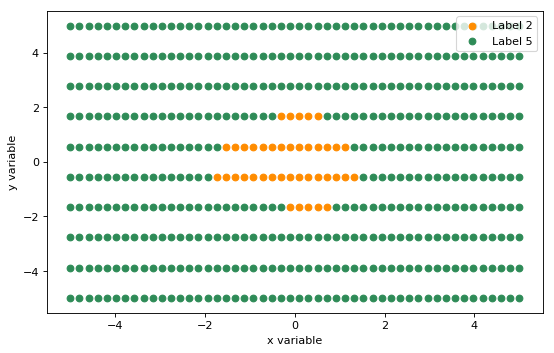

In [32]:
# Create the prediction model
vis_predictions = dnn_classifier.predict(input_fn=tf.estimator.inputs.numpy_input_fn(x={
        feature_x_name_current: np.array(vis_x_points),
        feature_y_name_current: np.array(vis_y_points)
    }, num_epochs=1, shuffle=False))

# Run the model by looking up each predicted class
vis_predicted_classes = [index_lookup[p["class_ids"][0]] for p in vis_predictions]
# Create a dataframe to store the results (easier to plot)
vis_df = pd.DataFrame({'x': vis_x_points, 'y':vis_y_points, 'label': vis_predicted_classes})
#print(vis_df)

# Plot each label
plt.figure(figsize=(8, 5), dpi=80)
for name,group in vis_df.groupby('label'):
    plt.scatter(x=group.x, y=group.y, color=next(colours), label='Label {}'.format(name))
plt.legend()
plt.xlabel('x variable')
plt.ylabel('y variable')
plt.show()

---

# Alternative Models

## AdadeltaOptimizer DNN [10,5]

This alternative model can be used to test different optimizers and activation functions.

There are variables that are set that will automatically update the results table below.

In [33]:
dnn1_dir = dnn_classifier_dir+'1'
# Clean folder (clear past accuracy results)
clean_dir(dnn1_dir)
# Setup model
dnn1 = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,n_classes=len(all_labels),
    ###
    hidden_units=[10,5], 
    optimizer=tf.train.AdadeltaOptimizer(),
    activation_fn=tf.nn.tanh,
    ###
    model_dir=dnn1_dir
)
# Train model
dnn1.train(input_fn=input_fn(my_training_df, label_lookup), steps=dnn_steps)
# Perform the evaluation
dnn1_evaluation_training = dnn1.evaluate(input_fn=input_fn(my_training_df, label_lookup), steps=len(my_training_df.index));
dnn1_evaluation_testing  = dnn1.evaluate(input_fn=input_fn(my_testing_df , label_lookup), steps=len(my_testing_df.index));
# Record the accuracy
dnn1_training_acc=dnn1_evaluation_training['accuracy']*100
dnn1_testing_acc=dnn1_evaluation_testing['accuracy']*100
dnn1_result_string = ['DNN','AdadeltaOptimizer', 'tanh', '[10,5]',
                      '{:0.2f}%'.format(dnn1_training_acc), '{:0.2f}%'.format(dnn1_testing_acc),getDT()]
# Print out Accuracy
print('Training Accuracy: {:f}%; '.format(dnn1_training_acc))
print( 'Testing Accuracy: {:f}%; '.format(dnn1_testing_acc))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './classifiers/dnn_classifier1', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./classifiers/dnn_classifier1\model.ckpt.
INFO:tensorflow:loss = 104.708, step = 1
INFO:tensorflow:global_step/sec: 1121.08
INFO:tensorflow:loss = 104.695, step = 101 (0.090 sec)
INFO:tensorflow:global_step/sec: 1218.64
INFO:tensorflow:loss = 104.681, step = 201 (0.082 sec)
INFO:tensorflow:global_step/sec: 1233.7
INFO:tensorflow:loss = 104.665, step = 301 (0.081 sec)
INFO:tensorflow:global_step/sec: 1281.15
INFO:tensorflow:loss = 104.649, step = 401 (0.079 sec)
INFO:tensorflow:global_step/sec: 1314.85
INFO:tensorflow:loss = 104.632, step = 501 (0.075 

INFO:tensorflow:Starting evaluation at 2017-10-17-15:08:31
INFO:tensorflow:Restoring parameters from ./classifiers/dnn_classifier1\model.ckpt-1500
INFO:tensorflow:Evaluation [1/50]
INFO:tensorflow:Evaluation [2/50]
INFO:tensorflow:Evaluation [3/50]
INFO:tensorflow:Evaluation [4/50]
INFO:tensorflow:Evaluation [5/50]
INFO:tensorflow:Evaluation [6/50]
INFO:tensorflow:Evaluation [7/50]
INFO:tensorflow:Evaluation [8/50]
INFO:tensorflow:Evaluation [9/50]
INFO:tensorflow:Evaluation [10/50]
INFO:tensorflow:Evaluation [11/50]
INFO:tensorflow:Evaluation [12/50]
INFO:tensorflow:Evaluation [13/50]
INFO:tensorflow:Evaluation [14/50]
INFO:tensorflow:Evaluation [15/50]
INFO:tensorflow:Evaluation [16/50]
INFO:tensorflow:Evaluation [17/50]
INFO:tensorflow:Evaluation [18/50]
INFO:tensorflow:Evaluation [19/50]
INFO:tensorflow:Evaluation [20/50]
INFO:tensorflow:Evaluation [21/50]
INFO:tensorflow:Evaluation [22/50]
INFO:tensorflow:Evaluation [23/50]
INFO:tensorflow:Evaluation [24/50]
INFO:tensorflow:Evalua

## AdagradOptimizer DNN [1]

In [34]:
dnn2_dir = dnn_classifier_dir+'2'
# Clean folder (clear past accuracy results)
clean_dir(dnn2_dir)
# Setup model
dnn2 = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,n_classes=len(all_labels),
    ###
    hidden_units=[1], 
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    activation_fn=tf.nn.tanh,
    ###
    model_dir=dnn2_dir
)
# Train model
dnn2.train(input_fn=input_fn(my_training_df, label_lookup), steps=dnn_steps)
# Perform the evaluation
dnn2_evaluation_training = dnn2.evaluate(input_fn=input_fn(my_training_df, label_lookup), steps=len(my_training_df.index));
dnn2_evaluation_testing  = dnn2.evaluate(input_fn=input_fn(my_testing_df , label_lookup), steps=len(my_testing_df.index));
# Record the accuracy
dnn2_training_acc=dnn2_evaluation_training['accuracy']*100
dnn2_testing_acc=dnn2_evaluation_testing['accuracy']*100
dnn2_result_string = ['DNN','AdagradOptimizer(0.05)', 'tanh', '[1]',
                      '{:0.2f}%'.format(dnn2_training_acc), '{:0.2f}%'.format(dnn2_testing_acc),getDT()]
# Print out Accuracy
print('Training Accuracy: {:f}%; '.format(dnn2_training_acc))
print( 'Testing Accuracy: {:f}%; '.format(dnn2_testing_acc))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './classifiers/dnn_classifier2', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./classifiers/dnn_classifier2\model.ckpt.
INFO:tensorflow:loss = 112.917, step = 1
INFO:tensorflow:global_step/sec: 1330.29
INFO:tensorflow:loss = 64.3685, step = 101 (0.075 sec)
INFO:tensorflow:global_step/sec: 1638.18
INFO:tensorflow:loss = 61.4981, step = 201 (0.061 sec)
INFO:tensorflow:global_step/sec: 1722.92
INFO:tensorflow:loss = 61.1562, step = 301 (0.057 sec)
INFO:tensorflow:global_step/sec: 1784.46
INFO:tensorflow:loss = 61.1045, step = 401 (0.057 sec)
INFO:tensorflow:global_step/sec: 1561.37
INFO:tensorflow:loss = 61.0949, step = 501 (0.065

INFO:tensorflow:Starting evaluation at 2017-10-17-15:08:44
INFO:tensorflow:Restoring parameters from ./classifiers/dnn_classifier2\model.ckpt-1500
INFO:tensorflow:Evaluation [1/50]
INFO:tensorflow:Evaluation [2/50]
INFO:tensorflow:Evaluation [3/50]
INFO:tensorflow:Evaluation [4/50]
INFO:tensorflow:Evaluation [5/50]
INFO:tensorflow:Evaluation [6/50]
INFO:tensorflow:Evaluation [7/50]
INFO:tensorflow:Evaluation [8/50]
INFO:tensorflow:Evaluation [9/50]
INFO:tensorflow:Evaluation [10/50]
INFO:tensorflow:Evaluation [11/50]
INFO:tensorflow:Evaluation [12/50]
INFO:tensorflow:Evaluation [13/50]
INFO:tensorflow:Evaluation [14/50]
INFO:tensorflow:Evaluation [15/50]
INFO:tensorflow:Evaluation [16/50]
INFO:tensorflow:Evaluation [17/50]
INFO:tensorflow:Evaluation [18/50]
INFO:tensorflow:Evaluation [19/50]
INFO:tensorflow:Evaluation [20/50]
INFO:tensorflow:Evaluation [21/50]
INFO:tensorflow:Evaluation [22/50]
INFO:tensorflow:Evaluation [23/50]
INFO:tensorflow:Evaluation [24/50]
INFO:tensorflow:Evalua

# Dynamic Results

Recompile this cell if you run any of the above classifiers.

**Labels:** {{all_labels}}

| Classifier | Optimizer  | Activation Function | Hidden Layers   | Training Accuracy | Testing Accuracy | Last Run |
|---|---|---|---|---|---|
|{{lin_result_string[0]}}|{{lin_result_string[1]}}|{{lin_result_string[2]}}|{{lin_result_string[3]}}|{{lin_result_string[4]}}|{{lin_result_string[5]}}|{{lin_result_string[6]}}|
|{{dnn_result_string[0]}}|{{dnn_result_string[1]}}|{{dnn_result_string[2]}}|{{dnn_result_string[3]}}|{{dnn_result_string[4]}}|{{dnn_result_string[5]}}|{{dnn_result_string[6]}}|
|{{dnn1_result_string[0]}}|{{dnn1_result_string[1]}}|{{dnn1_result_string[2]}}|{{dnn1_result_string[3]}}|{{dnn1_result_string[4]}}|{{dnn1_result_string[5]}}|{{dnn1_result_string[6]}}|
|{{dnn2_result_string[0]}}|{{dnn2_result_string[1]}}|{{dnn2_result_string[2]}}|{{dnn2_result_string[3]}}|{{dnn2_result_string[4]}}|{{dnn2_result_string[5]}}|{{dnn2_result_string[6]}}|

Note: This cell requires a jupyter notebook extension called "Python Markdown", if you don't see values then you don't have the extension installed. See https://github.com/ipython-contrib/jupyter_contrib_nbextensions and install via Anaconda's GUI or commandline.


## Non-Dynamic Results

**NOTE:** This section is results of the original notebook, these results do not automatically update.

**Labels:** [2,5]

| Classifier | Optimizer  | Activation Function | Hidden Layers   | Training Accuracy | Testing Accuracy | Last Run |
|---|---|---|---|---|---|
|Linear|AdagradOptimizer(0.05)|N/A|N/A|62.00%|50.00%|2017-10-15 23:18:15|
|DNN|AdagradOptimizer(0.05)|tanh|[10,5]|100.00%|100.00%|2017-10-15 23:13:42|
|DNN1|AdadeltaOptimizer|tanh|[10,5]|52.67%|52.00%|2017-10-15 23:15:59|
|DNN2|AdagradOptimizer(0.05)|tanh|[1]|72.67%|58.00%|2017-10-15 23:17:30|

---

# TensorBoard

TensorBoard is a way of visually debugging and analyzing TensorFlow models, and it is one of the main reasons TensorFlow was chosen for this project.

<img src='figs/tensorboard-ex.png'/>

Please see this video to get some hand-on demos of how to use TensorBoard: https://www.youtube.com/watch?v=eBbEDRsCmv4

**NOTE:** All `tf.estimator.Estimator` (`LinearClassifier`, `DNNClassifier`, ...) automatically create TensorBoard files, but if you create a custom classifier then you will need to run [tf.summary.FileWriter](https://www.tensorflow.org/api_docs/python/tf/summary/FileWriter). A tutorial is listed here: https://www.tensorflow.org/get_started/summaries_and_tensorboard

## Viewing Scalar Values Over Time

There is a section in TensorBoard that allows you to record and plot scalar values over time. `tf.estimator.Estimator` automatically records:
 * **Loss** The loss curve shows how the model is learning overtime; if the curve looks like it is still decreasing then increase the number of training steps.
   <img src="figs/tensorboard-loss.png">
 * **DNN** The DNN graphs are for each layer and the total graph and displays how many zero weights are in the graph at each training step. You can use this to determine if features are not used, and/or if there are too many layers/nodes.
   <img src="figs/tensorboard-dnn.png">
 * **Accuracy** 
 * **Accuracy Baseline** 
 * **AUC** 
 * **AUC Precision Recall** 
 * **Average Loss** 
 * **Global Step** 
 * **Label** 
 * **Prediction** 

---

# Pitfalls & Troubleshooting

As with most programming, there can be many problems when setting up and using other people's code. Here is a list of some errors I ran into when programming the above and blog/stackoverflow posts to information that solved the issue:

* **"WARNING:tensorflow:Input graph does not contain a QueueRunner. That means predict yields forever. This is probably a mistake."**
   * https://github.com/tensorflow/tensorflow/issues/5834
   * need to use this: 
   ```python
   my_predictions = list(itertools.islice(predictions,predict_num_samples))
   ```
* **"InvalidArgumentError: tensor_name = dnn/hiddenlayer_0/bias; shape in shape_and_slice spec [10] does not match the shape stored in checkpoint: [100]"**
  * If you have trained a model and then change the model and try to retrain there might be an issue with one of the checkpoints.
  * The solution is to delete all the files in the model directory (don't try to delete the folder!)
* **"Graph is finalized and cannot be modified."**
  * This means you are reusing the default graph, but have closed it. You need to either create a new graph or clear the kernel
  * Reference: https://www.tensorflow.org/programmers_guide/graphs#programming_with_multiple_graphs
* **Running forever with no output**
  * **Evaluate()** make sure to include `steps=len(test_dataset)`
* [TensorBoard not Working] **Unable to create process using**
  * Reason: TensorBoard used to be packaged with TensorFlow (v1.2.1), but now in version 1.3 it has been moved to its own repository but Anaconda doesn't have a package for it (yet)
  * **Ensure that you have TensorFlow version 1.3 and 1.2.1**
  * Activate your tensorflow anaconda environment in cmd: `activate Python36_TensorFlow`
  * Navigate to `D:\ProgramData\Anaconda2\pkgs\tensorflow-1.3.0-py36_0\Lib\site-packages\tensorflow` and copy `tensorboard/`
  * Navigate to `D:\ProgramData\Anaconda2\envs\Python36_TensorFlow\Lib\site-packages\tensorflow` and paste `tensorboard/` in there
* [TensorBoard not Displaying] **Error 404 for everything**
  * Full Error:
  ```
  (Python36_TensorFlow) C:\Users\jonathan\Jupyter\ml-tensorflow-iot-state-machine\classifiers>tensorboard --debug --logdir linear_classifier
Starting TensorBoard b'54' at http://Awesome-DELL:6006
(Press CTRL+C to quit)
WARNING:tensorflow:Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
WARNING:tensorflow:Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
WARNING:tensorflow:Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
WARNING:tensorflow:Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
WARNING:tensorflow:Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
WARNING:tensorflow:Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
WARNING:tensorflow:Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
WARNING:tensorflow:Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
WARNING:tensorflow:Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
WARNING:tensorflow:Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
WARNING:tensorflow:path ../external\plottable/plottable.css not found, sending 404
WARNING:tensorflow:path ../external\webcomponentsjs/webcomponents-lite.min.js not found, sending 404
WARNING:tensorflow:path ../external\plottable/plottable.css not found, sending 404
WARNING:tensorflow:path ../external\numericjs_numeric_min_js/file/numeric.min.js not found, sending 404
WARNING:tensorflow:path ../external\polymer/polymer.html not found, sending 404
  ```
  * Reason: TensorBoard used to be packaged with TensorFlow (v1.2.1), but now in version 1.3 it has been moved to its own repository but Anaconda doesn't have a package for it (yet)
  * **Ensure that you have TensorFlow version 1.3 and 1.2.1**
  * Activate your tensorflow anaconda environment in cmd: `activate Python36_TensorFlow`
  * Navigate to `D:\ProgramData\Anaconda2\pkgs\tensorflow-1.2.1-py36_0\Lib\site-packages\` and copy `external/`
  * Navigate to `D:\ProgramData\Anaconda2\envs\Python36_TensorFlow\Lib\site-packages\` and paste `external/` in there
* **WARNING:tensorflow:Casting `<dtype: 'float32'>` labels to bool.**
    * This occurs if you have only 2 classes (`len(all_labels) == 2`)
    * If you have 2 labels to begin with, then this is not a problem. A bool is more efficient to store 2 values than a 32 bit floating point, or 64 bit integer
    * If you have more than 2 labels, then this is a problem. You need to tell the classifier how many classes you are using, see `n_classes=` in creating the Linear Classifier and the creating the DNN classifier.

# Useful Links

* http://cv-tricks.com/tensorflow-tutorial/save-restore-tensorflow-models-quick-complete-tutorial/
* https://www.tensorflow.org/get_started/input_fn
* https://www.tensorflow.org/programmers_guide/variables
* https://www.tensorflow.org/programmers_guide/estimators
* https://www.tensorflow.org/programmers_guide/debugger
* https://www.tensorflow.org/programmers_guide/saved_model#using_savedmodel_with_estimators
* https://www.tensorflow.org/tutorials/linear
* https://github.com/aymericdamien/TensorFlow-Examples
* https://martin-thoma.com/tf-xor-tutorial/